# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.576545 -0.293244  0.629511 -1.188311 -0.197682 -0.391114   
      201547 -1.468249 -0.853781  0.517671  0.991523  0.755249  0.779594   
      201548 -0.604688  1.604767 -1.239378  0.543548  1.073936  0.471453   
      201549 -0.923333  0.277998 -1.151824  0.255301  0.388138  0.757482   
      201550  1.332219  0.464483 -0.058229 -1.858878  0.448462 -2.106787   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -1.133397 -1.218592 -1.464406  0.455543  ... -0.153236  0.175536   
      201547  0.079164 -0.988339  2.007702 -1.609132  ...  1.002971  1.145561   
      201548  0.725122 -1.008585 -0.932306  0.018494  ...  1.416242 -1.039110   
      201549 -0.871941 -0.278858  0.570421 -0.506493  ... -0.765999  0.817272   
      201550  0.829794 -2.116799  0.558020  0.427701  ...  0.555169 -0.956176   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  1.999168 -1.441090 -0.316870 -1.303909  1.085241  0.277983   
      201547  2.784719  0.705622 -0.513013 -1.772461 -0.492923  0.025568   
      201548 -0.855856  0.001017  1.306179  2.302579  0.759250  1.099233   
      201549 -0.053856  0.073011  0.677474 -0.609014  2.082386 -1.039273   
      201550  0.964989 -1.245547 -0.314558 -0.562920 -2.403474 -0.327390   

                  1023    Labels  
41001 201546  0.558658  0.064361  
      201547 -1.729810  0.091926  
      201548 -1.068440  0.082738  
      201549  0.883501  0.082738  
      201550  1.512990  0.211376  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820  1.126990 -0.077409 -0.555265  0.655990 -1.289295 -0.667857   
      201821  1.282643  0.423481 -0.275251 -1.006574  1.121875 -1.013018   
      201822 -0.311858  0.505837  0.364705  0.076682  0.259395 -0.893418   
      201823  0.906288  0.242448  0.326951  1.143897 -1.674355 -0.603984   
      201824 -1.511494  0.171362 -1.071322  1.167122 -1.361576 -0.640143   

                     6         7         8         9  ...      1015      1016  \
41001 201820 -0.529865  0.525767 -0.102355  1.502499  ... -0.112361  0.333586   
      201821  1.575295 -1.306695  0.465565  0.693947  ... -0.586871  1.900354   
      201822  0.107557  1.358757 -1.204570  0.571357  ...  0.026358  1.097025   
      201823  1.146232  0.332172  1.811156  0.581603  ...  0.092964  0.076285   
      201824 -1.477679 -0.562518  0.740299  1.392317  ... -0.591849  0.398240   

                  1017      1018      1019      1020      1021      1022  \
41001 201820  0.579913 -0.612204 -0.367036  0.824461  0.092015  1.721546   
      201821 -0.670428 -0.477287  1.266931 -0.143006  0.169311 -0.100943   
      201822  0.088386  0.425845 -1.382167  1.256699  0.447549 -0.561752   
      201823 -2.042617 -0.117963 -0.882066 -0.489573 -0.630276  0.920998   
      201824  0.315072  1.657689  0.748183  1.185539 -0.443714 -0.174485   

                  1023    Labels  
41001 201820 -2.760822 -0.275610  
      201821 -0.144936 -0.321552  
      201822  0.238241 -0.238856  
      201823 -1.542373 -0.321552  
      201824  1.002655 -0.293986  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

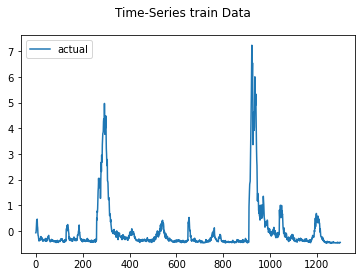

2023-03-15 17:15:15.025154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 17:15:15.025195: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 17:15:15.025217: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-15 17:15:15.025435: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 17:15:15.096661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 51.850
Test RMSE: 63.780
Test sMAPE: 110.636
Test R Squared: -3.209
{'mae': 51.84953102893902, 'rmse': 63.7800351863776, 'smape': 110.63578421882566, 'r2': -3.2093158111886506}


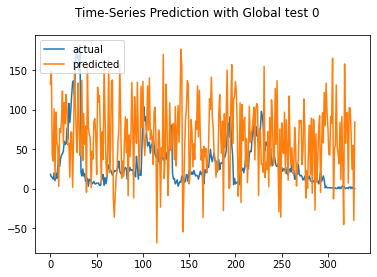

Test MAE: 27.991
Test RMSE: 36.408
Test sMAPE: 84.516
Test R Squared: -0.372
{'mae': 27.990550396207606, 'rmse': 36.40845618748987, 'smape': 84.51557446842392, 'r2': -0.37166017643456084}


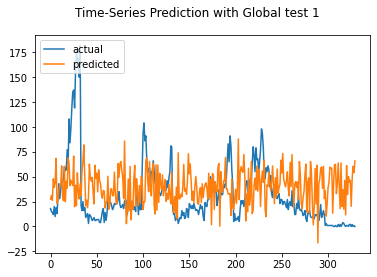

Test MAE: 34.937
Test RMSE: 42.657
Test sMAPE: 91.226
Test R Squared: -0.883
{'mae': 34.93707504435019, 'rmse': 42.65654177915342, 'smape': 91.22635790655708, 'r2': -0.8828394494683831}


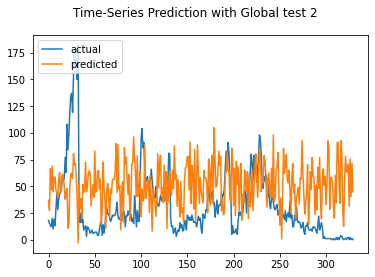

Test MAE: 28.036
Test RMSE: 37.017
Test sMAPE: 84.036
Test R Squared: -0.418
{'mae': 28.03625875566945, 'rmse': 37.01658623114169, 'smape': 84.03636590371765, 'r2': -0.4178645054013772}


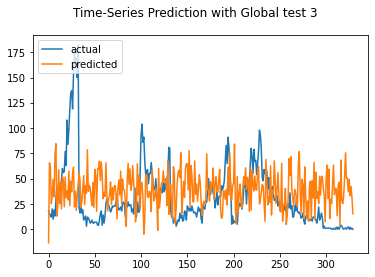

Test MAE: 36.377
Test RMSE: 42.857
Test sMAPE: 92.024
Test R Squared: -0.901
{'mae': 36.376806950027294, 'rmse': 42.85722838643533, 'smape': 92.02421804922007, 'r2': -0.9005975474088697}


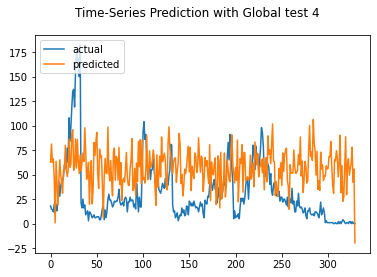

Test MAE: 33.666
Test RMSE: 41.609
Test sMAPE: 88.365
Test R Squared: -0.791
{'mae': 33.666311232610184, 'rmse': 41.60892732984285, 'smape': 88.36488193634509, 'r2': -0.7914926944122167}


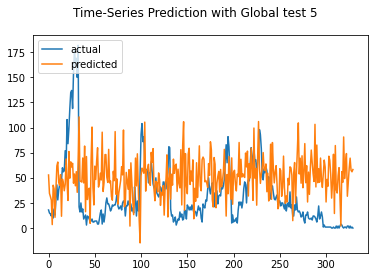

Test MAE: 37.119
Test RMSE: 43.870
Test sMAPE: 94.020
Test R Squared: -0.991
{'mae': 37.11941416046836, 'rmse': 43.86985707605312, 'smape': 94.02015909027428, 'r2': -0.9914730824930795}


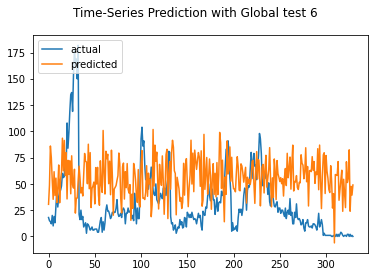

Test MAE: 38.830
Test RMSE: 45.793
Test sMAPE: 95.562
Test R Squared: -1.170
{'mae': 38.83039244882988, 'rmse': 45.79337163767488, 'smape': 95.56235499500343, 'r2': -1.1699375882340042}


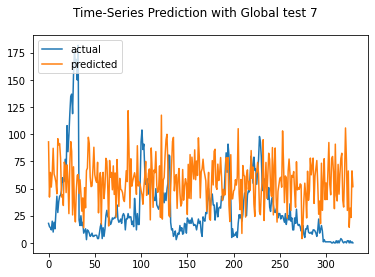

Test MAE: 27.595
Test RMSE: 37.472
Test sMAPE: 92.411
Test R Squared: -0.453
{'mae': 27.595161765317123, 'rmse': 37.47155991434651, 'smape': 92.41092728742069, 'r2': -0.45293286442329217}


Test MAE: 34.995
Test RMSE: 42.839
Test sMAPE: 89.702
Test R Squared: -0.899
{'mae': 34.994730052081024, 'rmse': 42.838710191870554, 'smape': 89.7021501835444, 'r2': -0.8989554425574817}


Test MAE: 31.173
Test RMSE: 39.042
Test sMAPE: 87.689
Test R Squared: -0.577
{'mae': 31.17294821039294, 'rmse': 39.04213756773555, 'smape': 87.6885463532841, 'r2': -0.5772813799636063}


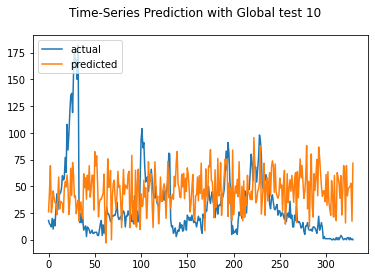

Test MAE: 34.329
Test RMSE: 41.754
Test sMAPE: 94.089
Test R Squared: -0.804
{'mae': 34.3287439781608, 'rmse': 41.754118647447704, 'smape': 94.0885823503273, 'r2': -0.8040170740354464}


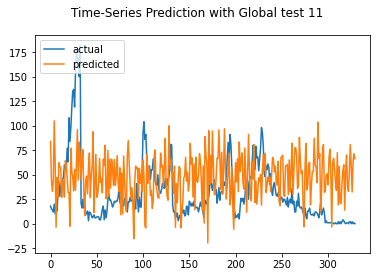

Test MAE: 27.880
Test RMSE: 36.733
Test sMAPE: 86.084
Test R Squared: -0.396
{'mae': 27.880144564005914, 'rmse': 36.73262735719594, 'smape': 86.08381911680031, 'r2': -0.39619470851701033}


Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 38.811
Test RMSE: 49.134
Test sMAPE: 109.664
Test R Squared: -1.498
{'mae': 38.81147315805552, 'rmse': 49.133957324764246, 'smape': 109.66355664666628, 'r2': -1.498075098581971}


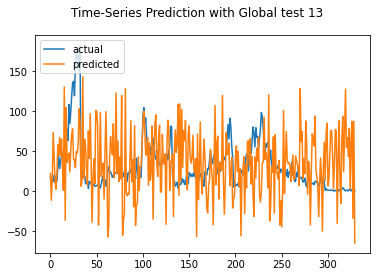

Test MAE: 33.350
Test RMSE: 40.885
Test sMAPE: 89.276
Test R Squared: -0.730
{'mae': 33.349897029454056, 'rmse': 40.88462410110638, 'smape': 89.27649792170084, 'r2': -0.7296650894147922}


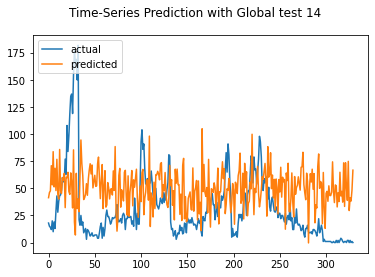

Test MAE: 28.673
Test RMSE: 37.737
Test sMAPE: 92.775
Test R Squared: -0.474
{'mae': 28.67252014782562, 'rmse': 37.73671454156144, 'smape': 92.77492685331873, 'r2': -0.4735679767171457}


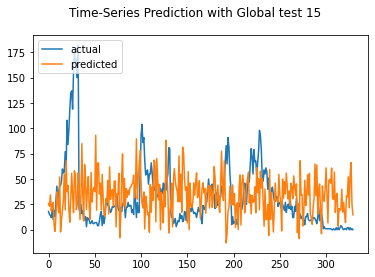

Test MAE: 37.242
Test RMSE: 43.213
Test sMAPE: 92.999
Test R Squared: -0.932
{'mae': 37.241720123002025, 'rmse': 43.213437254772764, 'smape': 92.99867305985475, 'r2': -0.9323225664174946}


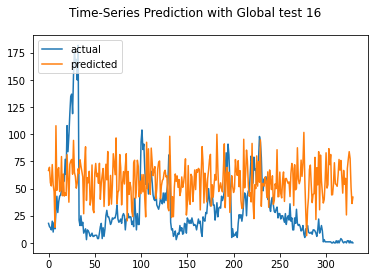

Test MAE: 39.155
Test RMSE: 46.517
Test sMAPE: 95.088
Test R Squared: -1.239
{'mae': 39.15522426547426, 'rmse': 46.517080540044645, 'smape': 95.08757807374997, 'r2': -1.2390660343671245}


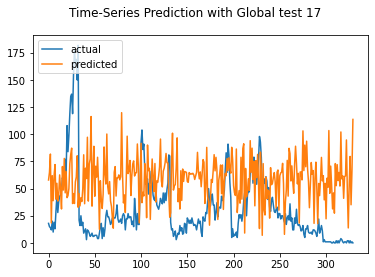

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 40.978
Test RMSE: 52.124
Test sMAPE: 110.923
Test R Squared: -1.811
{'mae': 40.97773810702969, 'rmse': 52.1239466544145, 'smape': 110.92348772593122, 'r2': -1.8113607997310481}


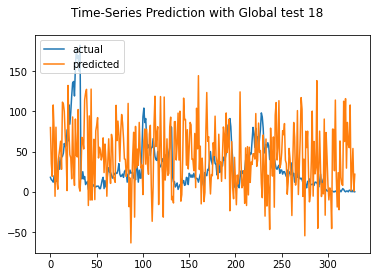

Test MAE: 34.349
Test RMSE: 41.710
Test sMAPE: 90.448
Test R Squared: -0.800
{'mae': 34.34929118156433, 'rmse': 41.71016459554788, 'smape': 90.44814109394864, 'r2': -0.8002209395784194}


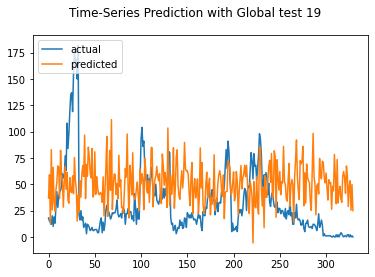

Test MAE: 34.348
Test RMSE: 41.525
Test sMAPE: 90.033
Test R Squared: -0.784
{'mae': 34.3480516982801, 'rmse': 41.52463428509476, 'smape': 90.03301637242733, 'r2': -0.7842414903038177}


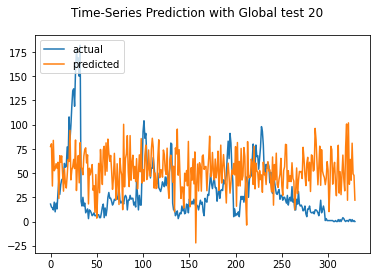

Test MAE: 30.913
Test RMSE: 39.073
Test sMAPE: 89.708
Test R Squared: -0.580
{'mae': 30.912527866435774, 'rmse': 39.072797185287534, 'smape': 89.70769376009264, 'r2': -0.5797596168065802}


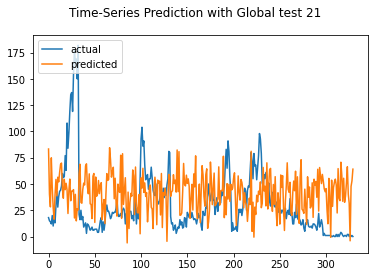

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 42.690
Test RMSE: 55.132
Test sMAPE: 109.379
Test R Squared: -2.145
{'mae': 42.689958564395255, 'rmse': 55.13244291360823, 'smape': 109.37948158623377, 'r2': -2.1452594406013707}


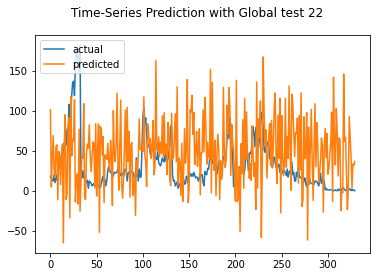

Test MAE: 38.307
Test RMSE: 45.657
Test sMAPE: 93.486
Test R Squared: -1.157
{'mae': 38.306889463193485, 'rmse': 45.6566371303756, 'smape': 93.48573086142919, 'r2': -1.1569984937799886}


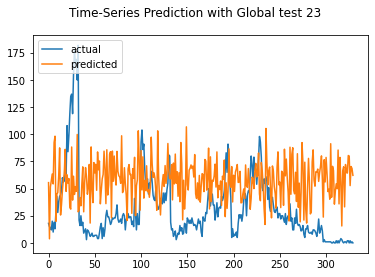

Test MAE: 34.260
Test RMSE: 41.378
Test sMAPE: 90.740
Test R Squared: -0.772
{'mae': 34.25977339479141, 'rmse': 41.378229970165705, 'smape': 90.74025517927764, 'r2': -0.7716821908976221}


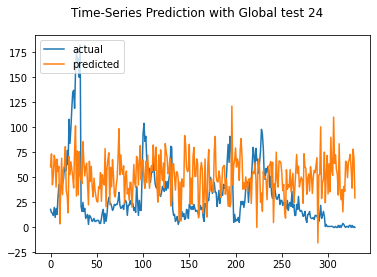

Test MAE: 31.266
Test RMSE: 39.404
Test sMAPE: 88.309
Test R Squared: -0.607
{'mae': 31.265654766604754, 'rmse': 39.4039365493095, 'smape': 88.30898606447121, 'r2': -0.6066497981516272}


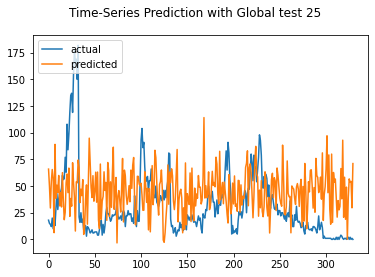

Test MAE: 42.964
Test RMSE: 49.673
Test sMAPE: 98.598
Test R Squared: -1.553
{'mae': 42.96441814971693, 'rmse': 49.6734383251884, 'smape': 98.59830505689685, 'r2': -1.5532329839896248}


Test MAE: 37.845
Test RMSE: 44.188
Test sMAPE: 93.055
Test R Squared: -1.020
{'mae': 37.845405315991606, 'rmse': 44.1879556838315, 'smape': 93.05481280006582, 'r2': -1.0204579729887429}


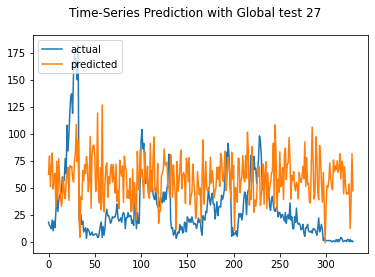

Test MAE: 35.934
Test RMSE: 42.628
Test sMAPE: 92.542
Test R Squared: -0.880
{'mae': 35.93422754208247, 'rmse': 42.62783175461486, 'smape': 92.54179343994987, 'r2': -0.880305808755895}


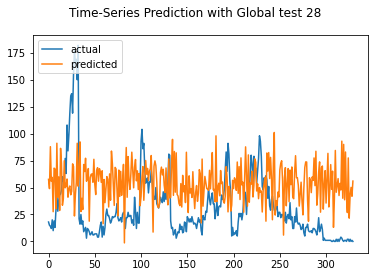

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 51.042
Test RMSE: 63.249
Test sMAPE: 113.479
Test R Squared: -3.139
{'mae': 51.041768461104596, 'rmse': 63.24884226138769, 'smape': 113.47923646079329, 'r2': -3.1394930942743695}


Test MAE: 33.934
Test RMSE: 42.376
Test sMAPE: 90.323
Test R Squared: -0.858
{'mae': 33.934390431281294, 'rmse': 42.37597298230703, 'smape': 90.3227383612783, 'r2': -0.8581525587476488}


Test MAE: 39.198
Test RMSE: 46.161
Test sMAPE: 95.220
Test R Squared: -1.205
{'mae': 39.19811366110137, 'rmse': 46.161087866797274, 'smape': 95.21958028570148, 'r2': -1.2049262712253106}


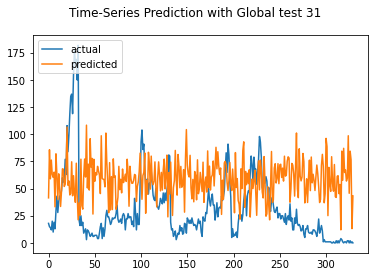

Test MAE: 39.137
Test RMSE: 46.382
Test sMAPE: 94.655
Test R Squared: -1.226
{'mae': 39.13681030851422, 'rmse': 46.38170463531132, 'smape': 94.65482846670865, 'r2': -1.2260525555773785}


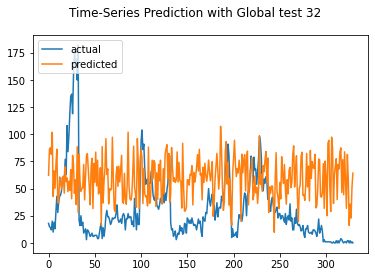

Test MAE: 41.502
Test RMSE: 48.508
Test sMAPE: 97.336
Test R Squared: -1.435
{'mae': 41.50159143245581, 'rmse': 48.50811116396268, 'smape': 97.33632086967557, 'r2': -1.4348416940442452}


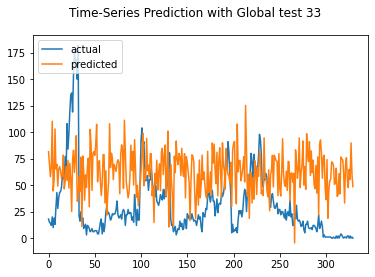

Test MAE: 28.713
Test RMSE: 38.136
Test sMAPE: 92.639
Test R Squared: -0.505
{'mae': 28.713337138621135, 'rmse': 38.136275607838584, 'smape': 92.63927543397965, 'r2': -0.5049378211519604}


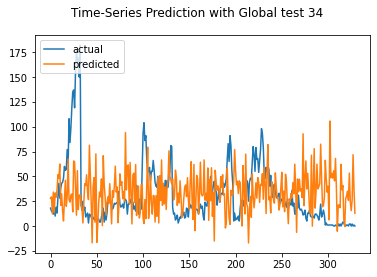

Test MAE: 32.603
Test RMSE: 40.273
Test sMAPE: 88.507
Test R Squared: -0.678
{'mae': 32.6028920173645, 'rmse': 40.27345599896247, 'smape': 88.50708266483838, 'r2': -0.6783394408463759}


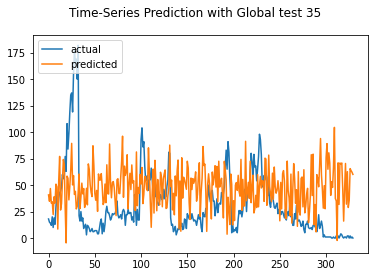

Test MAE: 35.446
Test RMSE: 43.515
Test sMAPE: 93.130
Test R Squared: -0.959
{'mae': 35.44578227879423, 'rmse': 43.515113333112424, 'smape': 93.1302047228097, 'r2': -0.9593961013248322}


Test MAE: 29.456
Test RMSE: 38.421
Test sMAPE: 87.914
Test R Squared: -0.527
{'mae': 29.456253883874776, 'rmse': 38.42074971277572, 'smape': 87.9142582875663, 'r2': -0.5274734557170537}


Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 47.561
Test RMSE: 61.286
Test sMAPE: 116.067
Test R Squared: -2.887
{'mae': 47.561130583647525, 'rmse': 61.285815139369774, 'smape': 116.06729825581482, 'r2': -2.8865292037199364}


Test MAE: 34.065
Test RMSE: 41.539
Test sMAPE: 90.670
Test R Squared: -0.785
{'mae': 34.065193156040074, 'rmse': 41.53894155994573, 'smape': 90.67014729802662, 'r2': -0.785471219673058}


Test MAE: 30.793
Test RMSE: 38.613
Test sMAPE: 89.595
Test R Squared: -0.543
{'mae': 30.793389494762277, 'rmse': 38.61316996951009, 'smape': 89.59478646795372, 'r2': -0.5428116695431218}


Test MAE: 34.787
Test RMSE: 41.626
Test sMAPE: 91.325
Test R Squared: -0.793
{'mae': 34.78709158770966, 'rmse': 41.62625245620972, 'smape': 91.32548861033561, 'r2': -0.7929848885674626}


Test MAE: 39.071
Test RMSE: 45.636
Test sMAPE: 94.181
Test R Squared: -1.155
{'mae': 39.07078797311494, 'rmse': 45.63615340276103, 'smape': 94.18125528321515, 'r2': -1.1550634647891127}


Test MAE: 26.373
Test RMSE: 37.286
Test sMAPE: 89.593
Test R Squared: -0.439
{'mae': 26.37307450450731, 'rmse': 37.28562940870926, 'smape': 89.5931192976515, 'r2': -0.43854999238323744}


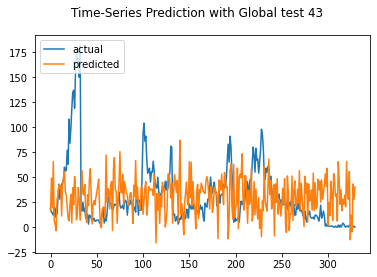

Test MAE: 34.827
Test RMSE: 41.556
Test sMAPE: 92.921
Test R Squared: -0.787
{'mae': 34.826775532419035, 'rmse': 41.555860091365375, 'smape': 92.92139860129029, 'r2': -0.7869259366908923}


Test MAE: 42.240
Test RMSE: 48.859
Test sMAPE: 97.636
Test R Squared: -1.470
{'mae': 42.2404587023186, 'rmse': 48.85945162864163, 'smape': 97.63557410428004, 'r2': -1.4702401625013084}


Test MAE: 32.351
Test RMSE: 41.040
Test sMAPE: 90.816
Test R Squared: -0.743
{'mae': 32.35144347927787, 'rmse': 41.040298426935706, 'smape': 90.81630795086107, 'r2': -0.7428620838829341}


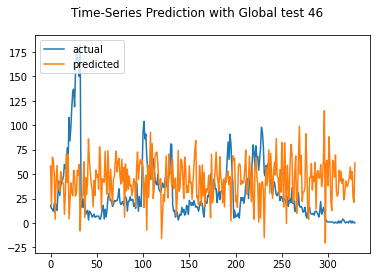

Test MAE: 35.306
Test RMSE: 42.250
Test sMAPE: 91.784
Test R Squared: -0.847
{'mae': 35.30614882237983, 'rmse': 42.250184111397104, 'smape': 91.78355399743018, 'r2': -0.8471374486996219}


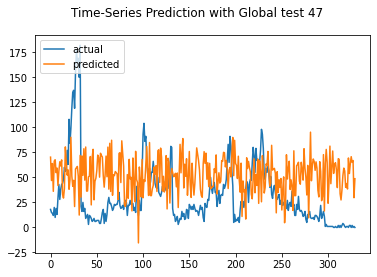

Test MAE: 34.426
Test RMSE: 41.482
Test sMAPE: 92.525
Test R Squared: -0.781
{'mae': 34.425773522348116, 'rmse': 41.48159057432314, 'smape': 92.52460691850824, 'r2': -0.7805443803346017}


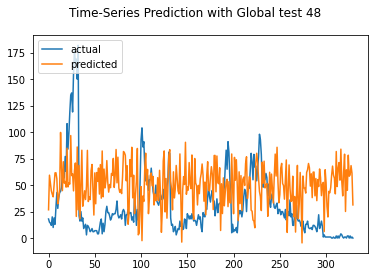

Test MAE: 30.042
Test RMSE: 38.076
Test sMAPE: 89.134
Test R Squared: -0.500
{'mae': 30.041558454163148, 'rmse': 38.07560213406372, 'smape': 89.13354302106336, 'r2': -0.500153024072272}


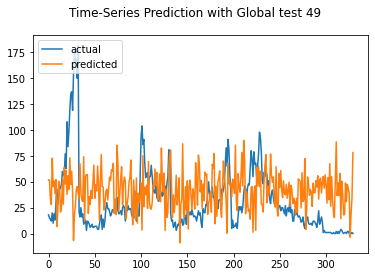

Test MAE: 34.038
Test RMSE: 40.427
Test sMAPE: 89.817
Test R Squared: -0.691
{'mae': 34.0375199693622, 'rmse': 40.42667106277683, 'smape': 89.81747744954899, 'r2': -0.6911337749248998}


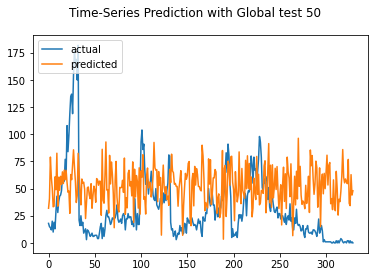

Test MAE: 40.979
Test RMSE: 47.669
Test sMAPE: 97.849
Test R Squared: -1.351
{'mae': 40.97932806737495, 'rmse': 47.669358787031136, 'smape': 97.8485569314102, 'r2': -1.3513680998099962}


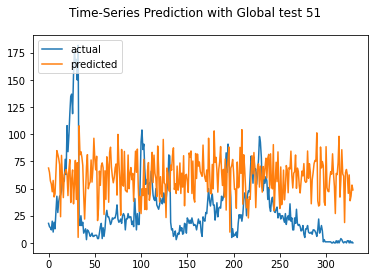

Test MAE: 27.606
Test RMSE: 36.674
Test sMAPE: 86.279
Test R Squared: -0.392
{'mae': 27.6063893773339, 'rmse': 36.674309942360914, 'smape': 86.27922055072946, 'r2': -0.3917649773523211}


Test MAE: 35.378
Test RMSE: 42.496
Test sMAPE: 92.518
Test R Squared: -0.869
{'mae': 35.37792877572956, 'rmse': 42.495715143134724, 'smape': 92.51758087064282, 'r2': -0.8686685915762076}


Test MAE: 31.708
Test RMSE: 38.692
Test sMAPE: 87.497
Test R Squared: -0.549
{'mae': 31.708212852478027, 'rmse': 38.69207086808827, 'smape': 87.49708748756092, 'r2': -0.549123173930687}


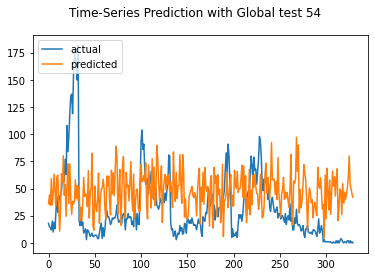

Test MAE: 37.140
Test RMSE: 43.407
Test sMAPE: 94.268
Test R Squared: -0.950
{'mae': 37.14040417237715, 'rmse': 43.40710872040368, 'smape': 94.26782936561567, 'r2': -0.9496817204822481}


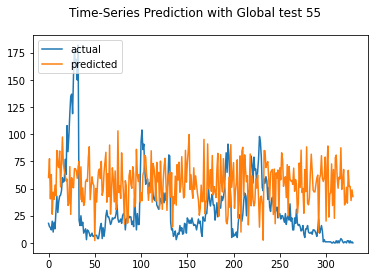

Test MAE: 38.481
Test RMSE: 45.035
Test sMAPE: 95.020
Test R Squared: -1.099
{'mae': 38.481317852843894, 'rmse': 45.03486946433179, 'smape': 95.0202749446798, 'r2': -1.0986490457878486}


Test MAE: 40.942
Test RMSE: 48.214
Test sMAPE: 95.767
Test R Squared: -1.405
{'mae': 40.94161832838348, 'rmse': 48.21409797992042, 'smape': 95.7674338770947, 'r2': -1.4054154376780863}


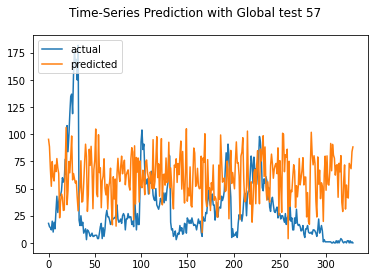

Test MAE: 34.104
Test RMSE: 40.939
Test sMAPE: 91.163
Test R Squared: -0.734
{'mae': 34.104064389431116, 'rmse': 40.93887711748239, 'smape': 91.16294178116303, 'r2': -0.7342585918385649}


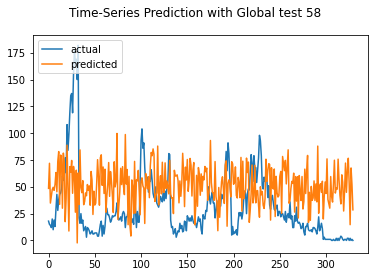

Test MAE: 37.139
Test RMSE: 44.011
Test sMAPE: 92.464
Test R Squared: -1.004
{'mae': 37.13917052384579, 'rmse': 44.01071749392624, 'smape': 92.46351401283671, 'r2': -1.0042823372085086}


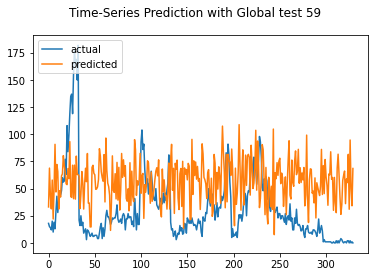

Test MAE: 31.513
Test RMSE: 39.888
Test sMAPE: 90.615
Test R Squared: -0.646
{'mae': 31.51277313449166, 'rmse': 39.888177220009126, 'smape': 90.61543758748289, 'r2': -0.6463811424489814}


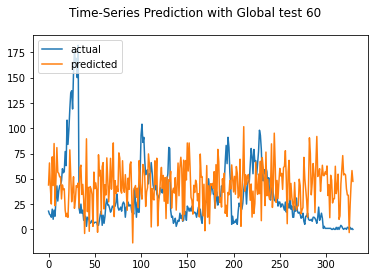

Test MAE: 38.557
Test RMSE: 45.523
Test sMAPE: 94.463
Test R Squared: -1.144
{'mae': 38.55658057675217, 'rmse': 45.52274362430974, 'smape': 94.46258322123145, 'r2': -1.1443657364400641}


Test MAE: 37.502
Test RMSE: 44.696
Test sMAPE: 94.081
Test R Squared: -1.067
{'mae': 37.501759653380425, 'rmse': 44.6962570513436, 'smape': 94.08058909025839, 'r2': -1.0672086505926832}


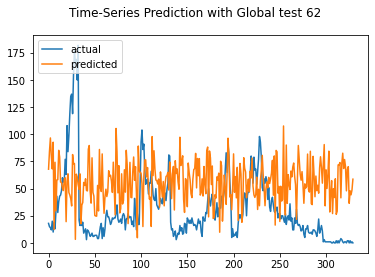

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 48.079
Test RMSE: 60.235
Test sMAPE: 115.103
Test R Squared: -2.754
{'mae': 48.07882598828186, 'rmse': 60.23468629265878, 'smape': 115.10303986137019, 'r2': -2.7543547544854046}


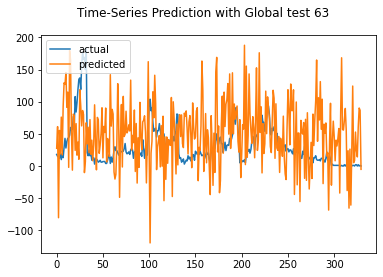

Test MAE: 35.591
Test RMSE: 43.002
Test sMAPE: 91.084
Test R Squared: -0.913
{'mae': 35.59053130980694, 'rmse': 43.00207653992819, 'smape': 91.08385505582335, 'r2': -0.9134664742878862}


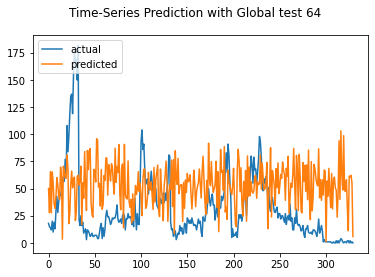

Test MAE: 32.059
Test RMSE: 39.604
Test sMAPE: 88.361
Test R Squared: -0.623
{'mae': 32.058864908868614, 'rmse': 39.60392280988052, 'smape': 88.36146134695345, 'r2': -0.6229995986105401}


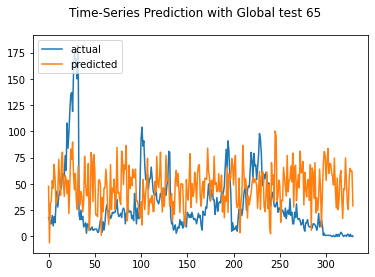

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 47.861
Test RMSE: 59.536
Test sMAPE: 107.399
Test R Squared: -2.668
{'mae': 47.86108305920339, 'rmse': 59.53569245103264, 'smape': 107.39946843651705, 'r2': -2.667725460686622}


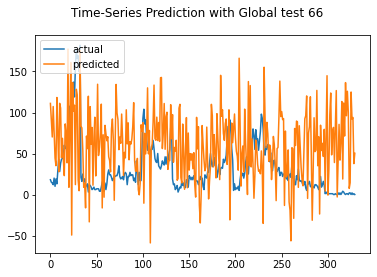

Test MAE: 27.170
Test RMSE: 36.453
Test sMAPE: 86.193
Test R Squared: -0.375
{'mae': 27.170132214101876, 'rmse': 36.45286408254915, 'smape': 86.19261191453845, 'r2': -0.3750082826432177}


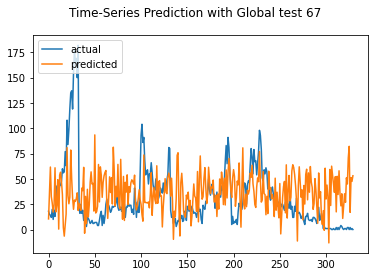

Test MAE: 25.325
Test RMSE: 34.936
Test sMAPE: 90.171
Test R Squared: -0.263
{'mae': 25.325413644042882, 'rmse': 34.93647049517449, 'smape': 90.17110762770369, 'r2': -0.26299042183191257}


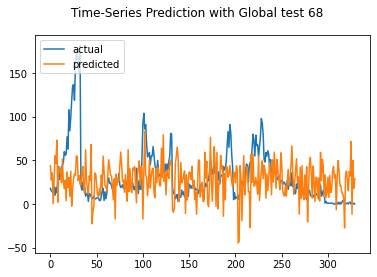

Test MAE: 32.194
Test RMSE: 39.900
Test sMAPE: 90.397
Test R Squared: -0.647
{'mae': 32.19365650009025, 'rmse': 39.899676783602736, 'smape': 90.39688312043003, 'r2': -0.6473305663165652}


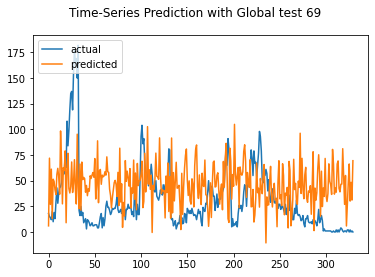

Test MAE: 39.234
Test RMSE: 45.812
Test sMAPE: 94.947
Test R Squared: -1.172
{'mae': 39.23365648587545, 'rmse': 45.81168960039832, 'smape': 94.94708191747681, 'r2': -1.1716739437136443}


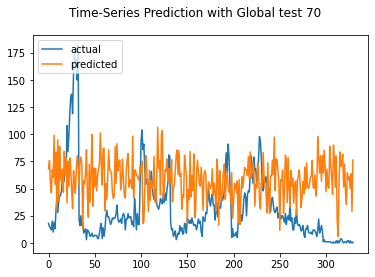

Test MAE: 32.767
Test RMSE: 40.500
Test sMAPE: 88.792
Test R Squared: -0.697
{'mae': 32.76703779237683, 'rmse': 40.499764521430016, 'smape': 88.79225729350803, 'r2': -0.6972546135047271}


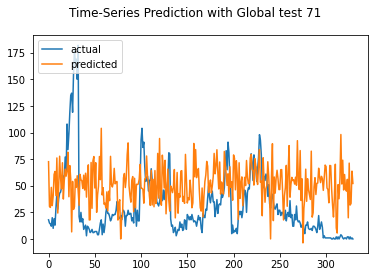

Test MAE: 27.852
Test RMSE: 37.821
Test sMAPE: 87.124
Test R Squared: -0.480
{'mae': 27.852237302245516, 'rmse': 37.82058496647391, 'smape': 87.12362561710201, 'r2': -0.48012531022196203}


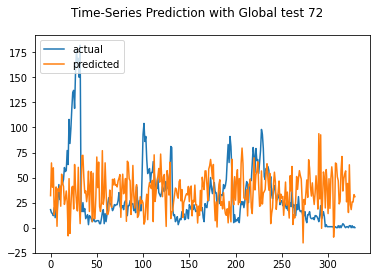

Test MAE: 35.440
Test RMSE: 42.771
Test sMAPE: 93.620
Test R Squared: -0.893
{'mae': 35.439852323766914, 'rmse': 42.77055153664655, 'smape': 93.6199612953271, 'r2': -0.8929175724382696}


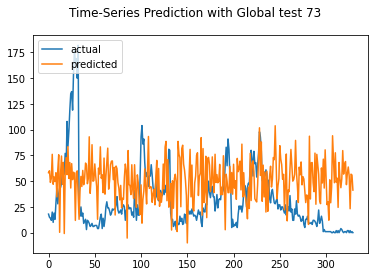

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 46.034
Test RMSE: 56.687
Test sMAPE: 111.976
Test R Squared: -2.325
{'mae': 46.03380071647239, 'rmse': 56.68653947215408, 'smape': 111.97570330986879, 'r2': -2.325078423149692}


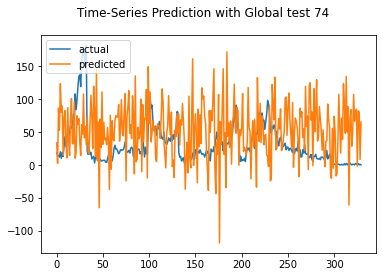

Test MAE: 31.295
Test RMSE: 39.133
Test sMAPE: 85.971
Test R Squared: -0.585
{'mae': 31.29503502701268, 'rmse': 39.13340578650486, 'smape': 85.97125408833192, 'r2': -0.5846643734430006}


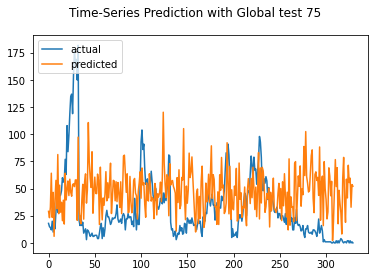

Test MAE: 29.003
Test RMSE: 36.763
Test sMAPE: 86.052
Test R Squared: -0.398
{'mae': 29.002703496046138, 'rmse': 36.76258427286838, 'smape': 86.05169036765852, 'r2': -0.3984729415436059}


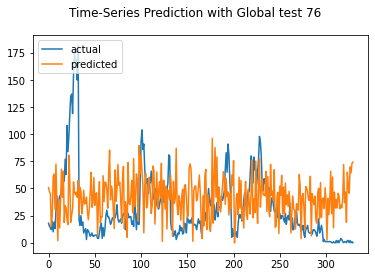

Test MAE: 34.983
Test RMSE: 42.373
Test sMAPE: 91.170
Test R Squared: -0.858
{'mae': 34.982647529154114, 'rmse': 42.37296608258405, 'smape': 91.17014179296683, 'r2': -0.8578888678024803}


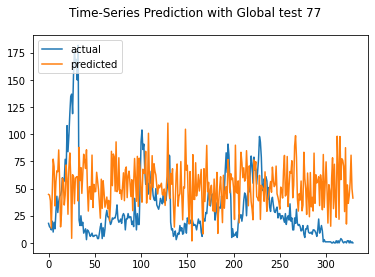

Test MAE: 29.068
Test RMSE: 37.275
Test sMAPE: 85.304
Test R Squared: -0.438
{'mae': 29.067622098778234, 'rmse': 37.27508565989068, 'smape': 85.304227193872, 'r2': -0.43773651193854235}


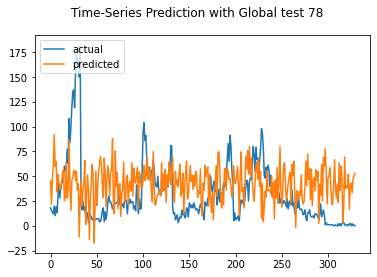

Test MAE: 29.256
Test RMSE: 38.136
Test sMAPE: 89.623
Test R Squared: -0.505
{'mae': 29.255596792788218, 'rmse': 38.13587549408447, 'smape': 89.62308647831591, 'r2': -0.5049062426533806}


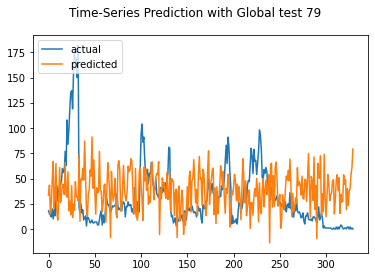

Test MAE: 30.255
Test RMSE: 38.936
Test sMAPE: 88.771
Test R Squared: -0.569
{'mae': 30.255001151471426, 'rmse': 38.93593278747654, 'smape': 88.77123399957473, 'r2': -0.5687118194415854}


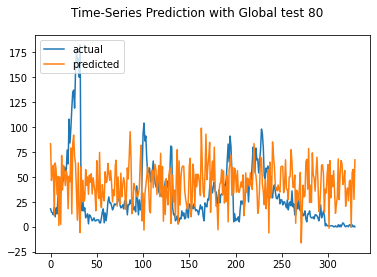

Test MAE: 30.138
Test RMSE: 38.875
Test sMAPE: 92.208
Test R Squared: -0.564
{'mae': 30.137954194347063, 'rmse': 38.8753983224165, 'smape': 92.20788866159472, 'r2': -0.5638377966530872}


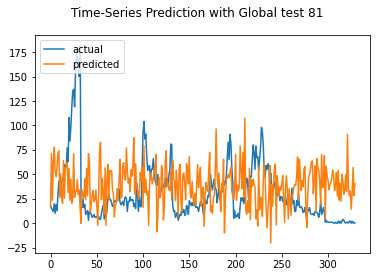

Test MAE: 33.207
Test RMSE: 40.557
Test sMAPE: 90.527
Test R Squared: -0.702
{'mae': 33.207341912896794, 'rmse': 40.557282959085015, 'smape': 90.52668580900361, 'r2': -0.7020789752281194}


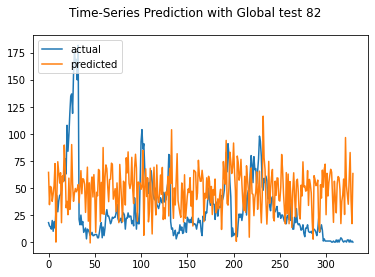

Test MAE: 28.836
Test RMSE: 37.305
Test sMAPE: 86.716
Test R Squared: -0.440
{'mae': 28.835578020504027, 'rmse': 37.304725294460056, 'smape': 86.71584617728489, 'r2': -0.4400238803789578}


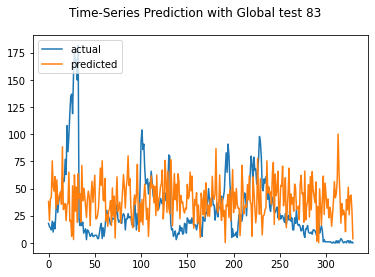

Test MAE: 25.859
Test RMSE: 36.823
Test sMAPE: 92.515
Test R Squared: -0.403
{'mae': 25.859017127481373, 'rmse': 36.82309767611288, 'smape': 92.51492485021586, 'r2': -0.403080670228916}


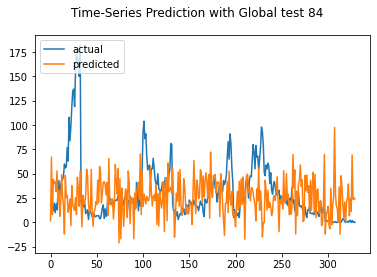

Test MAE: 31.514
Test RMSE: 38.675
Test sMAPE: 90.611
Test R Squared: -0.548
{'mae': 31.514444317059084, 'rmse': 38.67472882285784, 'smape': 90.61119815868356, 'r2': -0.5477348303750795}


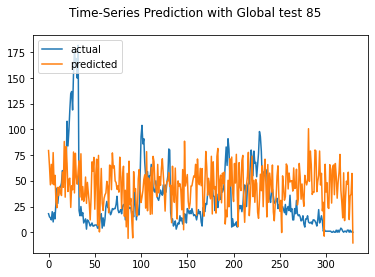

Test MAE: 36.082
Test RMSE: 43.621
Test sMAPE: 91.798
Test R Squared: -0.969
{'mae': 36.081945874654885, 'rmse': 43.62117554463984, 'smape': 91.79785794593101, 'r2': -0.9689592683184984}


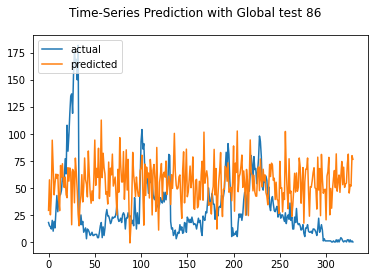

Test MAE: 33.936
Test RMSE: 41.369
Test sMAPE: 89.947
Test R Squared: -0.771
{'mae': 33.93570308974295, 'rmse': 41.36931890382221, 'smape': 89.94749316235179, 'r2': -0.7709191868940104}


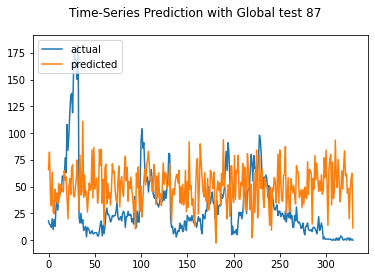

Test MAE: 39.049
Test RMSE: 45.909
Test sMAPE: 94.632
Test R Squared: -1.181
{'mae': 39.04927025925029, 'rmse': 45.90867470484161, 'smape': 94.63230069957675, 'r2': -1.1808787109432677}


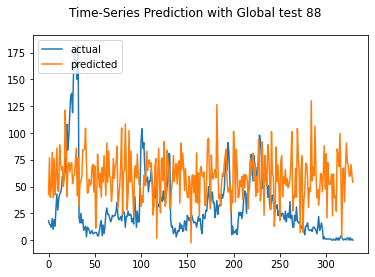

Test MAE: 35.792
Test RMSE: 42.713
Test sMAPE: 90.650
Test R Squared: -0.888
{'mae': 35.792058983896716, 'rmse': 42.713122949243854, 'smape': 90.64967960306927, 'r2': -0.8878376940268444}


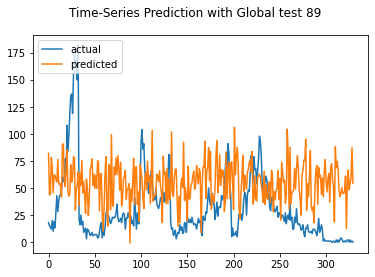

Test MAE: 33.300
Test RMSE: 40.411
Test sMAPE: 90.965
Test R Squared: -0.690
{'mae': 33.29991379831777, 'rmse': 40.41116157598634, 'smape': 90.96539819332072, 'r2': -0.6898364340845085}


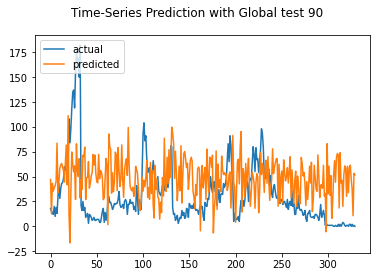

Test MAE: 35.156
Test RMSE: 43.126
Test sMAPE: 90.164
Test R Squared: -0.925
{'mae': 35.1564339697361, 'rmse': 43.12626836165554, 'smape': 90.16447299015528, 'r2': -0.9245347788495044}


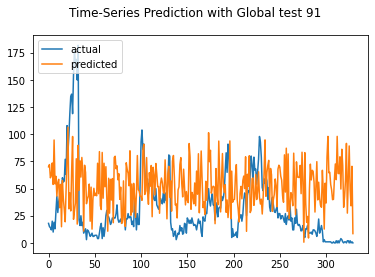

Test MAE: 29.511
Test RMSE: 37.394
Test sMAPE: 86.230
Test R Squared: -0.447
{'mae': 29.510855823845574, 'rmse': 37.3940118793017, 'smape': 86.22982739581377, 'r2': -0.4469253482944382}


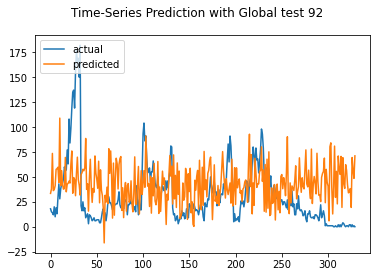

Test MAE: 38.071
Test RMSE: 45.119
Test sMAPE: 93.192
Test R Squared: -1.107
{'mae': 38.0712473378037, 'rmse': 45.119161316360945, 'smape': 93.1921972021608, 'r2': -1.1065124888508961}


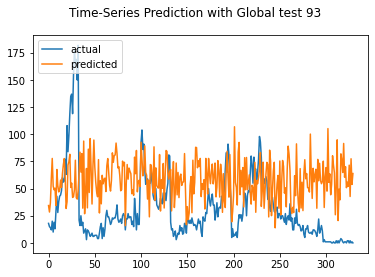

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 42.554
Test RMSE: 53.136
Test sMAPE: 115.836
Test R Squared: -1.922
{'mae': 42.55414779740244, 'rmse': 53.13648198408362, 'smape': 115.83634016618012, 'r2': -1.9216460216812146}


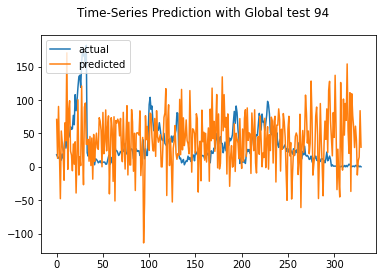

Test MAE: 39.416
Test RMSE: 46.626
Test sMAPE: 94.466
Test R Squared: -1.250
{'mae': 39.41615569808266, 'rmse': 46.62558866799335, 'smape': 94.46600822286464, 'r2': -1.2495241382609912}


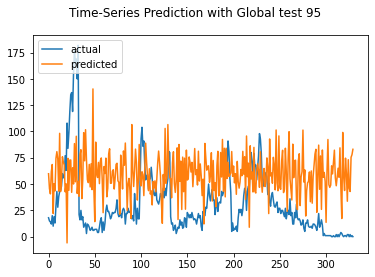

Test MAE: 32.685
Test RMSE: 40.378
Test sMAPE: 89.663
Test R Squared: -0.687
{'mae': 32.68462276892229, 'rmse': 40.377636264832894, 'smape': 89.66274870133878, 'r2': -0.6870338028052494}


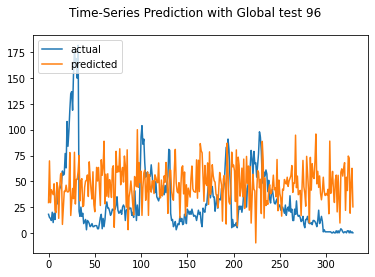

Test MAE: 31.406
Test RMSE: 39.524
Test sMAPE: 88.886
Test R Squared: -0.616
{'mae': 31.406016636165706, 'rmse': 39.52415821095294, 'smape': 88.88567223723193, 'r2': -0.616468551431719}


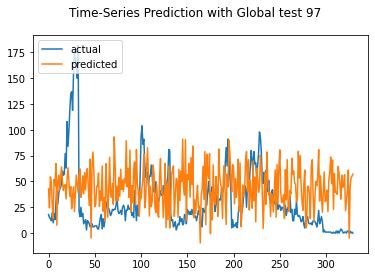

Test MAE: 31.946
Test RMSE: 39.115
Test sMAPE: 89.109
Test R Squared: -0.583
{'mae': 31.945855544552657, 'rmse': 39.114580864557254, 'smape': 89.10936214785157, 'r2': -0.5831401509800778}


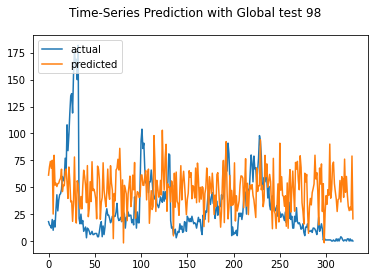

Test MAE: 33.607
Test RMSE: 41.588
Test sMAPE: 91.470
Test R Squared: -0.790
{'mae': 33.607310575246814, 'rmse': 41.58815028984935, 'smape': 91.47004640919933, 'r2': -0.7897040098901591}


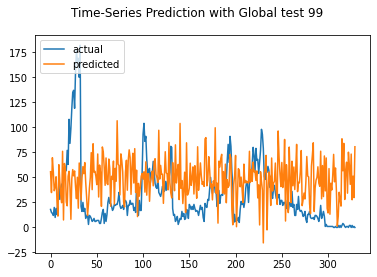

rmse : average=43.079, std=5.920
mae : average=34.994, std=5.424
smape : average=93.203, std=6.986
r2 : average=-0.957, std=0.591


([43.07884317471651, 5.919741173437929],
 [34.99353244530834, 5.424215153714577],
 [93.20278430336964, 6.986006669428825],
 [-0.9565659929034764, 0.5911214114116033])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')